# Midterm SE 4460A
# Student ID: XXXXXXXXX <font color = 'red'> (XX / 100) </font>

## General comments 
This Midterm integrates knowledge and skills acquired in the first half of the semester, especially in the 6 Assignments. You are allowed to use any document and source on your computer and look up documents on the internet. **You or not allowed to share documents, or communicate in any other way with people inside or outside the classroom during the midterm.** To finish the midterm in the alloted 2 hrs (an additonal 20 minutes is given to download/upload the exam/solutions), you will have to work efficiently. **Read the entirety of each question carefully.**

* Students with last name starting A-D: please use **"Data_Rack01.csv"**
* Students with last name starting F-L: please use **"Data_Rack02.csv"**
* Students with last name starting M-N: please use **"Data_Rack03.csv"**
* Students with last name starting P-S: please use **"Data_Rack04.csv"**
* Students with last name starting T-Z: please use **"Data_Rack05.csv"**

### Additional Guidance

If at any point you are asking yourself "are we supposed to...", then *write your assumptions clearly in your exam and proceed according to those assumptions.*

Good luck!




In [191]:
## Preliminaries
# Sets up the environment by importing 
# pandas, numpy, matplotlib, and statsmodels.

### YOU MAY ADD ADDITIONAL IMPORTS IF YOU WISH

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns
#from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


---
## Data set 

This exam objective is to develop a data-driven predictive model for the power use of an industrial refrigeration system.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line
- Volts_Line_to_Neutral




## Task 0: Data Preparation (5pts)

This task will focus on loading and pre-processing the data

In [206]:
# Load data, remove the empty column(s), 
# Then drop rows with any missing data ("NA").
# remove the 'DeviceName' column as well
data = pd.read_csv('Data_Rack01.csv')

data=data.drop(['Discharge_Pressure', 'DeviceName'],axis=1)
df = data.dropna()
df.head()
print(df.isna().sum().sum())
df.columns
df.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25751 entries, 0 to 25750
Data columns (total 10 columns):
Dew_Point                25751 non-null float64
Indoor_Humidity          25751 non-null float64
Indoor_Temperature       25751 non-null float64
Outdoor_Humidity         25751 non-null float64
Outdoor_Temperature      25751 non-null float64
Discharge_Temperature    25751 non-null float64
kW                       25751 non-null float64
Power_Factor             25751 non-null float64
Volts_Line_to_Line       25751 non-null float64
Volts_Line_to_Neutral    25751 non-null float64
dtypes: float64(10)
memory usage: 2.2 MB



## Task 1: Prediction (75pts)

This task will focus on building predictive models for the power consumed based on the other available data.

### ---
### Question 1.1 - Visualizing the Outcome (4pts)

Produce a plot that visualizes the marginal distribution of the power consumed ('kW' column).

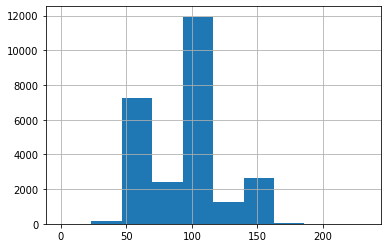

In [207]:
# Q1.1 - Code to produce plot

# Any plot of the marginal distribution is acceptable

df.kW.hist()

---
### Question 1.2 - Loss Functions (7pts)

Define two loss functions, one that measures the absolute difference between observations and predictions, and one that gives the mean number of instances for which the difference is less than or equal to a threshold `thresh`.

For example, if we had

obs = [1, 2, 3, 4, 5]
pred = [5, 4, 3, 2, 1]

Then threshold_loss(obs, pred, 2) should give 0.6


In [208]:
# Q1.2 - definitions of loss functions

def abs_diff_loss(obs, pred):
    
    # Resids is an array
    resids = abs(pred-obs)
    
    # Arrays have mean and std methods
    return resids.mean(), resids.std(ddof=1)
    
def threshold_loss(obs, pred, thresh):
    
    # Check if residual is within threshold
    resids = abs(obs-pred)>thresh
    
    # This turns booleans into ints.  1==True, 0==False
    # Most people used a loop.  That works too
    resids = resids.astype(int)
    return resids.mean(), resids.std(ddof=1)
    

# Did I do it right?
results = threshold_loss(np.arange(1,6), np.arange(5,0, -1), 2)
print(results)
    
    


(0.4, 0.5477225575051662)


---
### Question 1.3 (7pts)

Suppose you are using the absolute loss. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 1 units of loss with 95% confidence? Explain in 2 or 3 sentences the assumptions you used to compute the sample size. (There are several different approaches that are all acceptable.)

In [209]:
# Q1.3 - Computation to compute sample size for absolute difference

pred = df.kW.median()

# Use the median as a prediction to get a 
# rough estimate of the noise
mu, sigma = abs_diff_loss(pred, df.kW)



# Formula from class
n_abs_loss = np.ceil((2*sigma/1)**2)

print(n_abs_loss)

1365.0


#### Q1.3 - Explanation

Assume the standard deviation obtained from using median as prediction is good estimate for noise present in data.  Likely an overestimation.


---
### Question 1.4 (7pts)

Suppose you are using the threshold loss with a cutoff of 5 KW to measure performance. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 0.03 of the actual generalization performance with 95% confidence? Explain in 2 or 3 sentences the assumptions you used to compute the sample size. (There are several different approaches that are all acceptable.)

In [210]:
# Q1.4 - Computation to compute sample size for proportion below threshold

# This is the largest the sta
max_sigma = 0.5

n_thresh = np.ceil((2*max_sigma/0.03)**2)

print(n_thresh)

1112.0


#### Q1.4 - Explanation

The standard deviation of a binary random variale is $\sqrt{p(1-p)}$, where $p$ is the fraction of observations equal to 1.  The largest this can be is 0.5.  Just assume that true sigma is as large as possible. Here the random variable is a binomial  random variable with values 0 or 1 (above or below the threshold). 


###### ---
### Question 1.5 - Test Split (8pts)

Set aside some amount of data for testing, and retain the rest for training. Choose whichever amount you want based on your previous answers, and state which one you used. **Use your Student ID number as the *random_state* parameter value.**


In [211]:
# Q1.5 - Code to set aside data

# Use absolute difference n_est

X = df.drop('kW', axis = 'columns').values
DfFeatures = df.drop('kW', axis = 'columns')
y = df.kW.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = int(n_abs_loss),
                                                random_state = 19920908)

print(Xtrain.size, Xtest.size)
print(df.columns)

219474 12285
Index(['Dew_Point', 'Indoor_Humidity', 'Indoor_Temperature',
       'Outdoor_Humidity', 'Outdoor_Temperature', 'Discharge_Temperature',
       'kW', 'Power_Factor', 'Volts_Line_to_Line', 'Volts_Line_to_Neutral'],
      dtype='object')


### ---
### Question 1.6 - Simple Linear Model (5pts)

Using Ordinary Least Squares, build a model to predict power consumed (KW) as a linear function of the other variables in the data.


In [212]:
# Q1.6 - Code to produce simple OLS model

# Just build, don't fit.
simple_model = Pipeline([
    ('linear_regression', LinearRegression())
])

# If you wanted to be funny you could have used a dummy regressor
# This just returns the median of the training data!
# And I suppose *technically* it is a function of the other variables
# Can't get simpler than that!
dummy_model = DummyRegressor(strategy='median')


---
### Question 1.7 - More Complex Model (8pts)

Again using Ordinary Least Squares, develop second a model that has lower training error than the simple model.

In [213]:
# Q1.7 - Code to produce more complex OLS model

# Just Build, don't fit
# Most people used polynomial features.  I think that's a good idea

complex_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias = False)),
    ('linear_regression', LinearRegression())
])

# If you built a dummy regressor, all you needed to do here was pass
# linear regression.  We didn't expect you to know that,
# and I'm sure Dan didn't think of that.  This is just me
# being pedantic.

### Question 1.8 - Model Selection (10pts)

Use cross-validation to compare the two model spaces to select the one you think will result in the smallest generalization error for one of the loss functions you defined above. (Either one.) Explain why you chose the particular model space. 


In [214]:
# Q1.8 - Code to do cross-validation to compare models

# Should have trained on training data from part 1.5
# Cross validate mean absolute error directly
simple_cv = cross_val_score(dummy_model, 
                            Xtrain, 
                            ytrain, 
                            cv = 5, 
                            scoring=make_scorer(mean_absolute_error))


print('Simple model cv:', simple_cv.mean())
print('Simple CV: ', simple_cv)

complex_cv = cross_val_score(complex_model, 
                            Xtrain, 
                            ytrain, 
                            cv = 5, 
                            scoring=make_scorer(mean_absolute_error))

# This is the dummy regressor's CV
print('Complex Model:', complex_cv.mean())
print('Complex Model:', complex_cv)


Simple model cv: 22.562732372576953
Simple CV:  [22.47109471 22.32647119 22.67492311 22.80910396 22.53206889]
Complex Model: 15.262977097953916
Complex Model: [15.12021001 15.36096266 15.33033559 15.52142656 14.98195066]


#### Q1.8 - Explanation


If it comes down between the two, select complex model.  Cross valdiation is an estimate of generalization error, so looks like complex model should have smaller generalization error than simple model.

---
### Question 1.9 - Evaluation, Absolute Value, Normal approximation confidence interval (8pts)

Provide a point estimate for the generalization error of your chosen model using the absolute difference loss. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using a normal approximation.

In [215]:
# Q1.9 Evaluation - Absolute Value Loss - Use normal approximation
complex_model.fit(Xtrain, ytrain)
preds = complex_model.predict(Xtest)
mu, sigma = abs_diff_loss(ytest, preds)

# Critical vaue should be approx 2.  Using 1.96 is also fine.
# Since training is so small, I am going to use the true critical value
# Because it results in a wider confidence interval
tcrit = t.ppf(0.975, df=n_abs_loss-1)
radius = tcrit*sigma/np.sqrt(n_abs_loss)

#In order of appearence: Left end, point estimate, right end
np.arange(-1,2)*radius + mu

array([14.11282367, 14.82418263, 15.5355416 ])

---
### Question 1.10 - Evaluation, Threshold, Bootstrap approximation confidence interval (11pts)

Provide a point estimate for the generalization error of your model using the threshold loss with a threshold of 4. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using the bootstrap.

In [216]:
# Q1.10 Evaluation - Threshold Loss - Use bootstrap

# This one is tough
# I'm assuming I can use the sample size I chose earlier
# and not the one I computed for this loss

numits = 10000
thresh = 4
bootstrap_loss=np.zeros(numits)
complex_model.fit(Xtrain, ytrain)


for i in range(numits):
    # Sample incicies from
    ix = np.random.randint(low=0, high = int(n_abs_loss), size = int(n_abs_loss))
    # Passing randomly sampled indicies is the same as randomly sampling
    xboot = Xtest[ix]
    yboot = ytest[ix]
    ypreds = complex_model.predict(xboot)
    mu, sigma = threshold_loss(yboot, ypreds, thresh)
    bootstrap_loss[i]=mu
    

#Interval is quantiles
interval_estimate = np.quantile(bootstrap_loss, [0.025, 0.5, 0.975])

#In order of appearance: Left estimate, point estimate, right estimate
print(interval_estimate)


[0.82857143 0.84761905 0.86666667]


---
---
## Task 2 - Regularized Linear Regression Model

---
### Question 2.1 (10 pts)  

Use L1 regularization to determine the best set of variables to include in a predictive model. Add a penalty of $\lambda \sum_{i}{|\beta_i|_1}$ ($\beta_i$ are your regression coefficients) to the linear regression model. Vary the regularization parameter $\lambda$ between 0.2 and 200, evenly spaced in log-space.

Apply all necessary preprocessing steps to your variables to be able to compare meanfully between different predictors in the model.

Plot the coefficient path, i.e. the size of the regression coefficients relative to the size of the the regularization paramter. Which two variables are the two most important predictors?

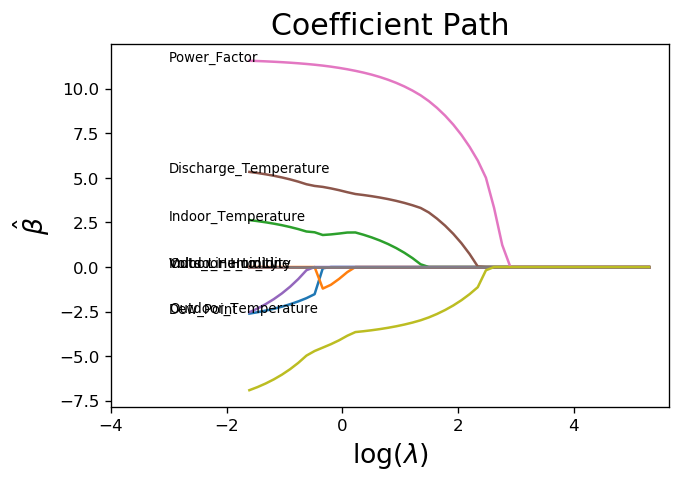

In [217]:
regularization_strength = np.exp(np.linspace(np.log(0.2),np.log(200),50))

coefs = np.zeros((regularization_strength.size, X.shape[1]))

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('linear_regression', Lasso(alpha=L, 
                                               fit_intercept=True)) 
    ])
    
    lasso_pipe.fit(Xtrain, ytrain)
    coefs[i] = lasso_pipe.named_steps['linear_regression'].coef_    

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), coefs)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$\hat{\beta}$', fontsize = 16)
ax.set_title('Coefficient Path', fontsize = 18)
ax.set_xlim(-4,None)

for i, name in enumerate(DfFeatures.columns[:-1]):
    
    ax.annotate(name, xy = (-3, coefs[0,i]), ha = 'left', fontsize = 8)


#### Q2.1 - Explanation



---
### Question 2.2 (10 pts)

Using the same model and the range of regularisation parameters as in T2, Q1, determine the 10-fold crossvalidated performance for different values of the L1-regularisation parameter. 

Make a plot of the crossvalidated score against $log(\lambda)$. Based on this criterion, what is the optional setting of the L1-regularization parameter? At this value, which variables contribute to the prediction?

Text(0, 0.5, 'cvScoreMean')

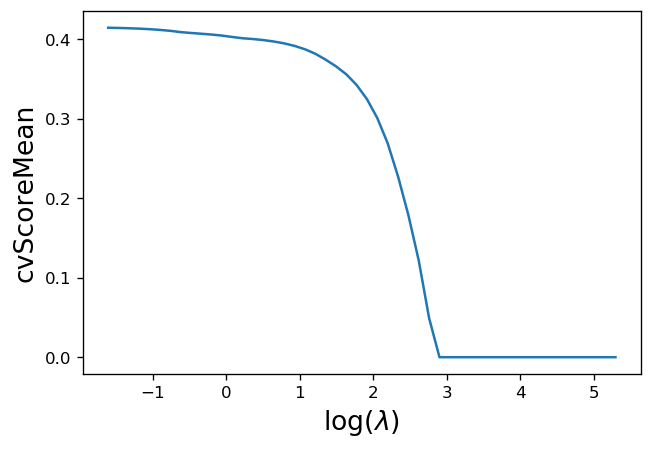

In [218]:
regularization_strength = np.exp(np.linspace(np.log(0.2),np.log(200),50))

coefs = np.zeros((regularization_strength.size, X.shape[1]))

cvScoreMean=np.zeros(regularization_strength.size)

for i,L in enumerate(regularization_strength):
    lasso_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('linear_regression', Lasso(alpha=L, 
                                               fit_intercept=True)) 
    ])
    cv_score = cross_val_score(lasso_pipe, Xtrain, ytrain, cv=10)
    cvScoreMean[i]= cv_score.mean()

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), cvScoreMean)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'cvScoreMean', fontsize = 16)

In [219]:
bestI=np.argmax(cvScoreMean)
print('Best lambda:',regularization_strength[bestI])
print('Variables included:',DfFeatures.columns[coefs[bestI]!=0])

Best lambda: 0.2
Variables included: Index([], dtype='object')
